# TP Vocodeur de Phase

$\textit{DESVALL\'EES Henri}$

$\textit{LALAY Louis}$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from soundfile import read

# TFCT

## 1.1 Généralités sur la TFCT

### Définition en convention passe bas

$$
\hat{X}_0(f,b) = \sum_{n\in \mathcal{Z}} x(n)w(n-b)e^{-2i\pi f n}
$$

Produit de convolution :

$$
(x*y)(m) = \sum_{n \in \mathcal{Z}} x(n)y(m-n)
$$

En considérant $f = f_0$ comme une constante, on a :
\begin{align*}
    \hat{X}_0(b) &= \sum_{n\in \mathcal{Z}} x(n)w(n-b)e^{-2i\pi f_0 n}\\
    &=e^{-2i\pi f_0 b} \sum_{n\in \mathcal{Z}} x(n)w_-(b-n)e^{2i\pi f_0 (b-n)}\\
    &= e^{-2i\pi f_0 b}(x*g)(b)
\end{align*}
Avec $g(n) = w_-(n)e^{2i\pi f_0 n}$ et $w_-(n) = w(-n)$.

Si on calcule la TFTC de $g$, on a :

\begin{align*}
TFTC[g](\nu) &= G(\nu)\\
&= \sum_{n \in \mathcal{Z}} w(-n)e^{2i\pi f_0 n}e^{-2i\pi \nu n}\\
&=\sum_{n \in \mathcal{Z}} w(-n)e^{-2i\pi (\nu-f_0) n}
\end{align*}

On pose le changement de variable $\nu_2 = f_0 - \nu$

\begin{align*}
G(\nu) &=\sum_{n \in \mathcal{Z}} w(-n)e^{2i\pi \nu_2 n}
\end{align*}

On pose le changement de variable  $n_2 = -n$

\begin{align*}
G(\nu) &=\sum_{n_2 \in \mathcal{Z}} w(n_2)e^{-2i\pi \nu_2 n_2}
\end{align*}

Finalement, $G(\nu) = W(f_0-\nu)$. 


En terme de filtrage, on peut voir la STFT comme un filtrage par un filtre ayant comme fonction de transfert $W(f_0-\nu)$ et modulé par $e^{-2i\pi f_0 b}$.

### Définition en convention passe bande

$$
\hat{X}_{loc}(f,b) = \sum_{n\in \mathcal{Z}} x(n+b)w(n)e^{-2i\pi f n}
$$

On pose le changement de variable $n_1 = n+b$ :
\begin{align*}
    \hat{X}_{loc}(f,b) &= \sum_{n_1\in \mathcal{Z}} x(n_1)w(n_1-b)e^{-2i\pi f (n_1-b)}\\
    &=e^{2i\pi f b}\sum_{n_1\in \mathcal{Z}} x(n_1)w(n_1-b)e^{-2i\pi f n_1}\\
    &=e^{2i\pi f b}\hat{X}_0(f,b)\\
    &= (x*g)(b)
\end{align*}

Pour l'implémentation numérique, on prend une tranche de signal que l'on multiplie avec la fenêtre. Cela correspond à l'approche passe-bande.

In [2]:
def stft(signal, /, window, Nfft=1024, hop_size=32):
    window_len = len(window)
    n_step = (len(signal) - window_len) // hop_size
    stft = np.zeros((Nfft, n_step), dtype=np.complex_)
    for k in range(n_step):
        frame = signal[k * hop_size : k * hop_size + window_len] * window
        stft[:, k] = np.fft.fft(frame, Nfft)
    return stft

## 1.2 Overlap-add reconstruction

### Condition de reconstruction parfaite 

On utilisera les notations suivantes : 
- $N_t$ : Nombre de fenêtres temporelles
- $R$ : Hop size
- $N$ : Taille des fenêtres
- $M$ : Taille de la FFT
- $w_a$ : Fenêtre de calcul de la STFT
- $w_s$ : Fenêtre de reconstruction
$$
y_w(n, u)=\frac{1}{N}\sum_{k=0}^{N-1}STFT(u,k)e^{2i\pi\frac{k}{M}(n)}
$$

On part de la définition du signal reconstruit pour trouver une condition sur les fenêtres.

\begin{align*}
y(n)&=\sum_{u=0}^{N_t-1}w_s(n - u\cdot R)y_w(n-u*R, u)\\
&=\sum_{u=0}^{N_t-1}w_s(n - u\cdot R)\frac{1}{N}\sum_{k=0}^{N-1}STFT(u,k)e^{2i\pi\frac{k}{M}(n-u\cdot R)}\\
&=\sum_{u=0}^{N_t-1}w_s(n - u\cdot R)\frac{1}{N}\sum_{k=0}^{N-1}  \sum_{m=0}^{N-1} w_a(m)x(m+u\cdot R)    e^{2i\pi\frac{k}{M}(n-u\cdot R-m)}\\
&=\sum_{u=0}^{N_t-1}w_s(n - u\cdot R) \sum_{m=0}^{N-1} w_a(m)x(m+u\cdot R)  \frac{1}{N}\sum_{k=0}^{N-1}  e^{2i\pi\frac{k}{M}(n-u\cdot R-m)}\\
\end{align*}

Ici il faut remarquer que $\frac{1}{N}\sum_{k=0}^{N-1}  e^{2i\pi\frac{k}{M}(n-u\cdot R-m)} = {\huge \bf1}_{n-m-u\cdot R} $ qui vaut 1 quand $m=n-u\cdot R$ et 0 sinon. On substitue donc dans l'équation précédente :

\begin{align*}
y(n)&=\sum_{u=0}^{N_t-1}w_s(n - u\cdot R) \sum_{m=0}^{N-1} w_a(m)x(m+u\cdot R)  {\huge \bf1}_{n-m-u\cdot R}\\
&=\sum_{u=0}^{N_t-1}w_s(n - u\cdot R) w_a(n-u\cdot R)x(n)\\
&=x(n)\sum_{u=0}^{N_t-1}w_s(n - u\cdot R) w_a(n-u\cdot R)
\end{align*}

On retrouve bien la condition portant sur le Complete Overlap ADD :
$$
\sum_{u=0}^{N_t-1}w_s(n - u\cdot R) w_a(n-u\cdot R)=1
$$

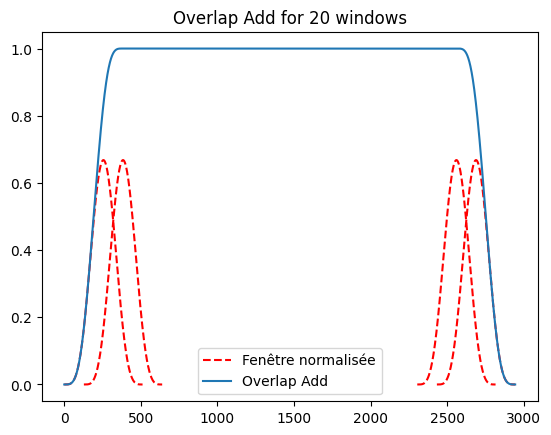

In [3]:
def ola(window, hop_size, n = 20, show=True):
    if n<4:
        n=4
    window_len = len(window)
    ola_out = np.zeros(hop_size * (n - 1) + window_len)
    for k in range(n):
        ola_out[k * hop_size : k * hop_size + window_len] += window
    if show:
        plt.figure()
        plt.plot(window, "--r")
        plt.plot(
            np.arange(hop_size, hop_size + window_len),
            window,
            "--r",
        )
        plt.plot(
            np.arange(hop_size * (n - 2), hop_size * (n - 2) + window_len),
            window,
            "--r",
        )
        plt.plot(
            np.arange(hop_size * (n - 1), hop_size * (n - 1) + window_len),
            window,
            "--r",
            label="Fenêtre normalisée",
        )
        plt.plot(ola_out, label="Overlap Add")
        plt.title(f"Overlap Add for {n} windows")
        plt.legend()
        plt.show()
    return ola_out


## Overlap Add pour une fenêtre de STFT égale à la fenêtre de reconstruction
window = np.hanning(512)
hop_size = 128
norm = np.sum(window**2) / hop_size
_ = ola(window * window / norm, hop_size)

## Resynthèse

### Egaliseur Audio

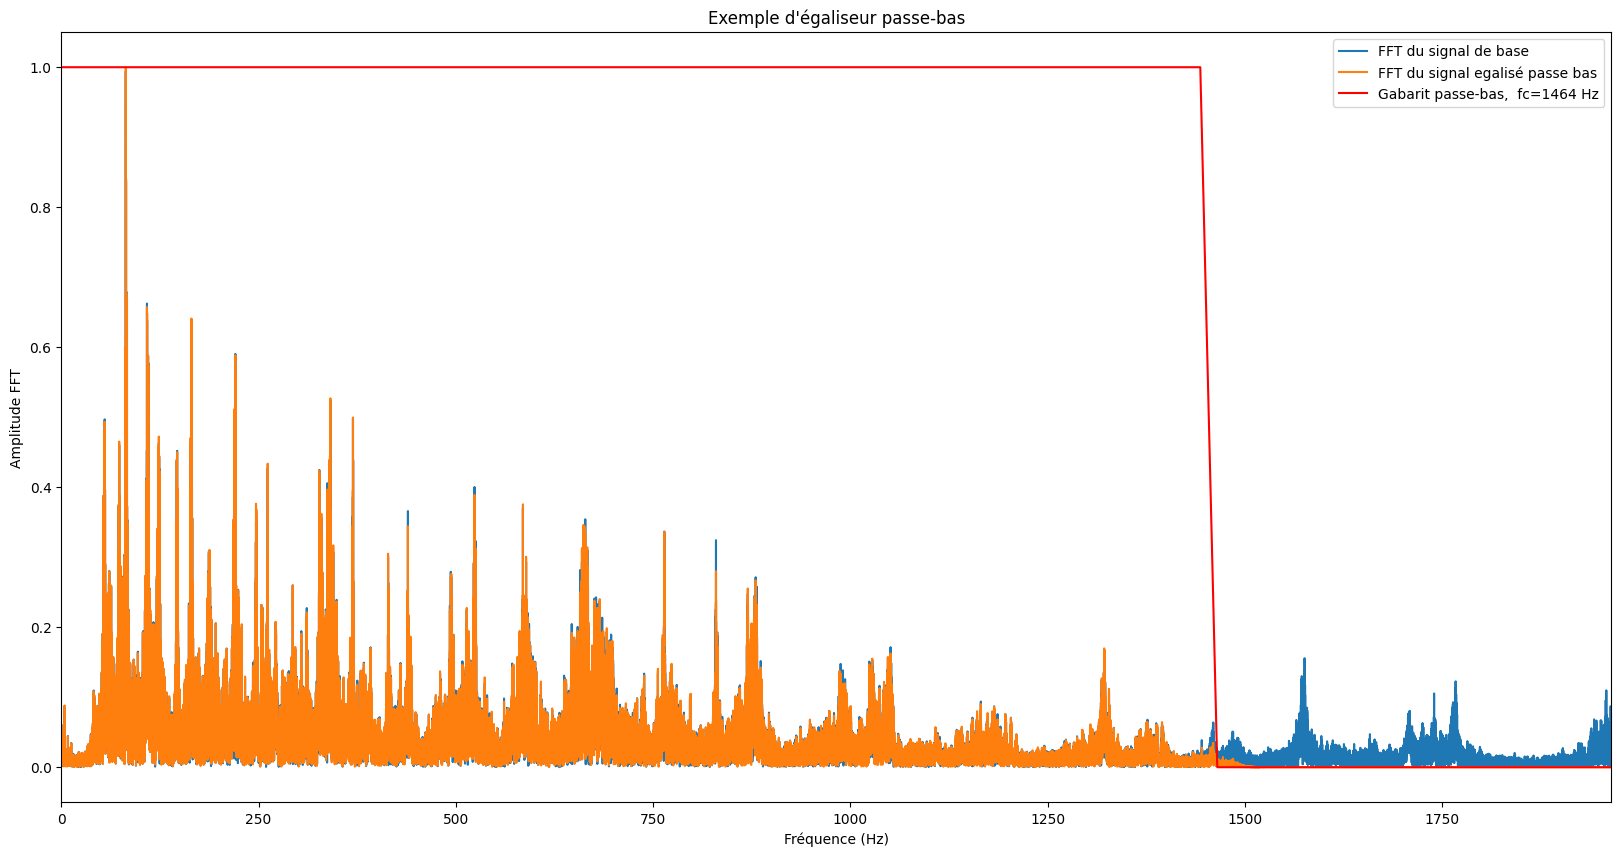

In [4]:
def egaliseur(stft, window, hop_size, weights):
    Nw = len(window)
    M, Nt = stft.shape
    if len(weights) != M:
        print(
            f"Erreur sur les poids : la FFT est de taille {M=} alors que les poids sont de taille {len(weights)=}"
        )
        return
    out = np.zeros(Nt * hop_size + Nw)
    for k in range(Nt):
        deb = k * hop_size
        fin = deb + Nw
        out[deb:fin] += window * np.fft.ifft(stft[:, k] * weights, M)[:Nw].real
    return out


signal, fs = read("song.wav")
signal_len = signal.shape[0]
window_len = 1024
window = np.hanning(window_len)
hop_size = window_len // 4
Nfft = 2 * window_len

poids_passe_bas = np.ones(Nfft)
f_coupure = Nfft // 30
ind_f_coupure = int(f_coupure / Nfft * signal_len)
poids_passe_bas[f_coupure:-f_coupure] = 0
frequences_plot_poids = np.linspace(0,fs,Nfft)

Xtilde = stft(signal, window=window, hop_size=hop_size, Nfft=Nfft)
fft_x_tilde = np.abs(np.fft.fft(signal))
signal_egal = egaliseur(Xtilde, window / norm, hop_size, poids_passe_bas)
fft_egal = np.abs(np.fft.fft(signal_egal))

normalisation_fft = max(np.max(fft_x_tilde), np.max(fft_egal))
frequences = np.linspace(0,fs,signal_len)

plt.figure(figsize=(20,10))
plt.plot(frequences, fft_x_tilde/normalisation_fft, label="FFT du signal de base")
plt.plot(frequences[:len(fft_egal)], fft_egal/normalisation_fft, label="FFT du signal egalisé passe bas")
# plt.vlines(f_coupure/Nfft*fs, 0, 1, colors="r", label=f"Fréquence de coupure = {f_coupure/Nfft*fs:.0f} Hz")
plt.plot(frequences_plot_poids, poids_passe_bas, "r", label=f"Gabarit passe-bas,  fc={f_coupure/Nfft*fs:.0f} Hz")
plt.xlim((0, f_coupure/Nfft*fs + 500))
plt.ylabel('Amplitude FFT')
plt.xlabel('Fréquence (Hz)')
plt.title("Exemple d'égaliseur passe-bas")
plt.legend()
plt.show()

# Etirement temporel

## Phase de la TFCT
### Montrer que la phase de la TFCT est bornée à $2\pi$ pour toute $f$
On considère un signal de type exponentiel

$$
x_{f_0}(n) = e^{2i\pi f_0n}
$$

Puis on calcule sa TFCT en 2 instants $b_1 = s$ et $b_2 = s+1$

\begin{align*}
    \hat{X}_{f_0}(b_1, f) &= \sum_{n\in \mathcal{Z}} x_{f_0}(n)w(n-b_1)e^{-2i\pi f n}\\
    &=\sum_{n\in \mathcal{Z}} w(n-s)e^{-2i\pi (f-f_0) n}\\
    &=e^{2i\pi (f_0-f) s}W(f-f_0)
\end{align*}

\begin{align*}
    \hat{X}_{f_0}(b_2, f) &= \sum_{n\in \mathcal{Z}} x_{f_0}(n)w(n-b_2)e^{-2i\pi f n}\\
    &=\sum_{n\in \mathcal{Z}} w(n-s-1)e^{-2i\pi (f-f_0) n}\\
    &=\sum_{n\in \mathcal{Z}} w(n-s)e^{-2i\pi (f-f_0) (n+1)}\\
    &=e^{2i\pi (f_0-f) (s+1)}W(f-f_0)
\end{align*}

La différence de phase entre ces deux instants vaut 

$$
\Delta \phi = 2\pi (f_0-f)
$$

On peut retourner l'expression pour en déduire la fréquence du signal 
$$
f_0 = f +\frac{\Delta_\phi}{2\pi}
$$

$f$ et $f_0$ étant des fréquences normalisées, on a $f\in [0,1]$ et $f_0\in [0,1]$. Donc, on a $f-f_0\in [-1,1]$. Ainsi, on a bien 
$$
|\Delta \phi| = |2\pi (f-f_0)| \leq 2\pi
$$
### Vérification expérimentale


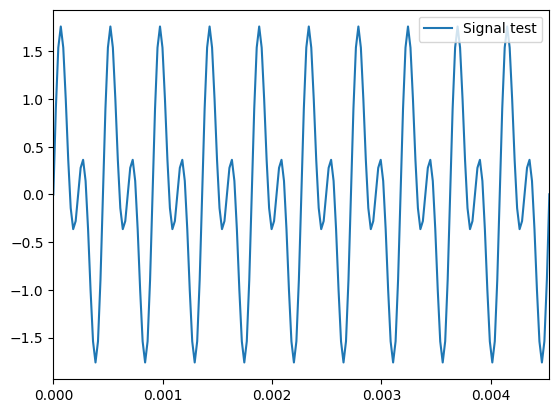

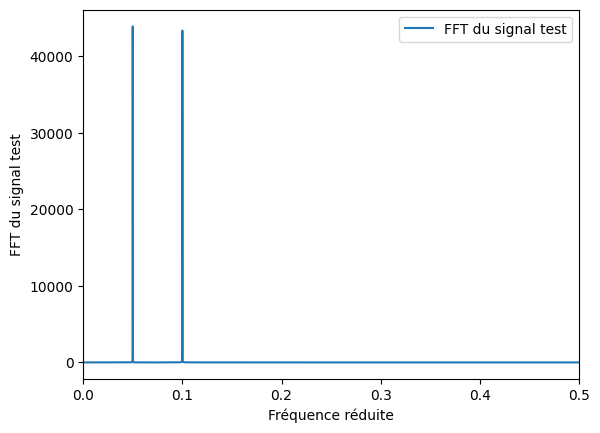

In [5]:
# Tracer la phase pour toutes les fréquences
FE = 44100
duree = 2
n_points = duree * FE
f0 = 0.05
f1 = 0.1
vec_temps = np.linspace(0, duree, n_points)
freq_reduite = np.linspace(0, 1, n_points)
x_f0 = np.sin(2 * np.pi * f0 * FE * vec_temps) + np.sin(2 * np.pi * f1 * FE * vec_temps)

## Faire des subplots à la place et légender
plt.figure()
plt.plot(vec_temps, x_f0, label="Signal test")
plt.xlim(0, 10 / (f0 * FE))
plt.legend()
plt.show()
plt.figure()
plt.plot(freq_reduite, np.abs(np.fft.fft(x_f0)), label="FFT du signal test")
plt.xlim(0, 0.5)
plt.legend()
plt.xlabel("Fréquence réduite")
plt.ylabel("FFT du signal test")
plt.show()

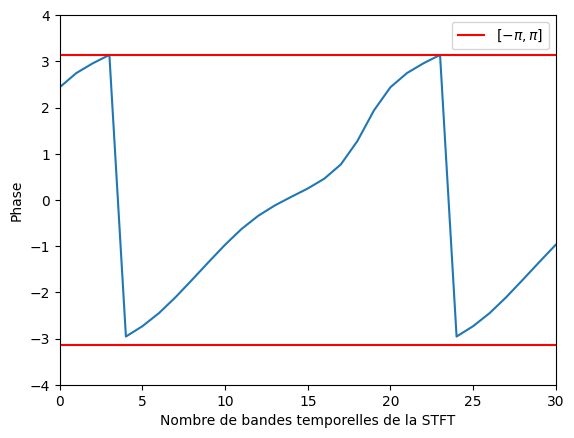

In [6]:
window = np.hanning(1024)
stft_x_f0 = stft(x_f0, window, 1024, 1)
angle = np.angle(stft_x_f0[10,:])

plt.figure()
plt.plot(angle)
plt.hlines([np.pi, -np.pi], 0, 30, 'r', label = "[$-\pi, \pi$]")
plt.ylim(-4,4)
plt.xlim(0,30)
plt.xlabel("Nombre de bandes temporelles de la STFT")
plt.ylabel("Phase")
plt.legend()
plt.show()


La phase ne doit pas augmenter de plus de $2\pi$ entre 2 échantillons temporels, ce qui est bien le cas observé ici.
### Instants non successifs

On considère maintenant 2 instants non successifs pour la TFCT : $b_1 = s$ et $b_2 = s+R$

\begin{align*}
    \hat{X}_{f_0}(b_1, f) &= \sum_{n\in \mathcal{Z}} x_{f_0}(n)w(n-b_1)e^{-2i\pi f n}\\
    &=\sum_{n\in \mathcal{Z}} w(n-s)e^{-2i\pi (f-f_0) n}\\
    &=e^{2i\pi (f_0-f) s}\sum_{n\in \mathcal{Z}} w(n)e^{-2i\pi (f-f_0) n}\\
    &=e^{2i\pi (f_0-f) s}W(f-f_0)
\end{align*}

\begin{align*}
    \hat{X}_{f_0}(b_2, f) &= \sum_{n\in \mathcal{Z}} x_{f_0}(n)w(n-b_2)e^{-2i\pi f n}\\
    &=\sum_{n\in \mathcal{Z}} w(n-s-R)e^{-2i\pi (f-f_0) n}\\
    &=\sum_{n\in \mathcal{Z}} w(n)e^{-2i\pi (f-f_0) (n+R+s)}\\
    &=e^{2i\pi (f_0-f) (s+R)}W(f-f_0)
\end{align*}

La différence de phase entre ces deux instants vaut 

\begin{align*}
\Delta \phi &= 2\pi R(f_0-f)\\
|\Delta \phi| \leq 2\pi  &\Leftrightarrow |2\pi R(f-f_0)| \leq 2\pi\\
&\Leftrightarrow R|(f-f_0)| \leq 1\\
&\Leftrightarrow R|\Delta_f| \leq 1\\
\end{align*}

### Sous échantillonnage

On considère le signal $x$ échantillonné à la fréquence $F_e$, que l'on souhaite sous échantilloner d'un facteur $m$. On note $f_{max}$ la fréquence la plus élevée présente dans $x$.
Condition de sous échantillonnage sans perte :
$$
f_{max}\leq \frac{F_e}{2m}
$$
Soit en fréquence réduite :
$$
\nu_{max}\leq \frac{1}{2m}
$$

Pour un signal réel, on peut définir $f_{max}$ comme étant la dernière fréquence non négligeable du spectre de $x$.

On peut borner $\Delta_f$ avec cette condition de sous échantillonnage sans perte :

\begin{align*}
\Delta_f &= f-f_0\\
&\leq f_{max} - f_0\\
&\leq \frac{1}{2m} -f_0
\end{align*}

On en déduit :
$$
R\left|\frac{1}{2m} -f_0\right| \leq 1
$$

### Hop size d'analyse variable

On a $R_s$ le temps d'incrément de synthèse et $R_a$ le temps d'incrément d'analyse. On veut montrer que si $R_s$ est égal à la valeur limite de la condition de sous échantillonnage sans perte et que le temps de sortie est inférieur au temps d'entrée, alors il y aura introduction de distorsion. Intuitivement, on peut se dire que sous échantillonner à la limite correspond à prendre le nombre minimum d'échantillons permettant de représenter le signal d'entrée. Si le son est contracté, alors cela revient à ne pas prendre tout les échantillons. Or comme on dispose du nombre minimum d'échantillons, cela introduit de la distorsion.


### Intégration de l'étirement temporel à la reconstruction

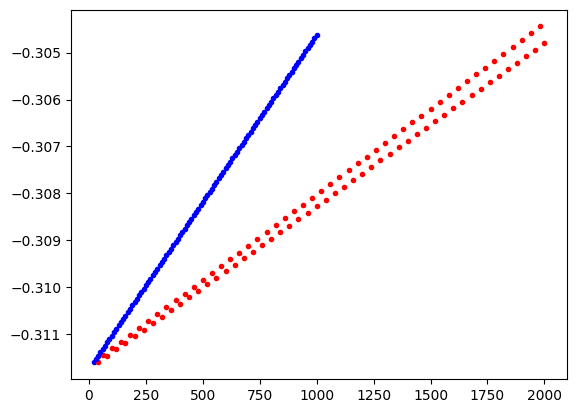

In [87]:
## Modification de la reconstruction pour ajouter de l'étirement
def etirement_temporel(signal, hop_size_analyse, hop_size_reconstruction, window):
    stft_signal = stft(signal, window, Nfft=len(window), hop_size=hop_size_analyse)
    n_freq, n_pas_temps = stft_signal.shape
    nouveau_signal = np.zeros(
        n_pas_temps * hop_size_reconstruction + len(window), dtype=np.complex_
    )
    nouveau_signal[: len(window)] = np.fft.ifft(stft_signal[:, 0])
    phase_avant = np.angle(stft_signal[:, 0])
    coef_corr_overlap = np.sum(window**2) / hop_size_reconstruction
    for i in range(1, n_pas_temps):
        # Calcul de la phase
        fft_apres = stft_signal[:, i]
        phase_apres = np.angle(fft_apres)
        amplitudes = np.abs(fft_apres)

        # Correction de phase
        delta_phase = phase_apres - phase_avant
        new_delta_phase = hop_size_reconstruction * delta_phase / hop_size_analyse
        new_phase_apres = phase_avant + new_delta_phase

        # Calcul de la nouvelle fft
        nouvelle_fft = amplitudes * np.exp(1j * new_phase_apres)

        # FFT inverse
        deb = i * hop_size_reconstruction
        fin = i * hop_size_reconstruction + len(window)
        nouveau_signal[deb:fin] += np.fft.ifft(nouvelle_fft) * window

        phase_avant = new_phase_apres
    return nouveau_signal / coef_corr_overlap


n_signal = etirement_temporel(x_f0, 10, 20, window)

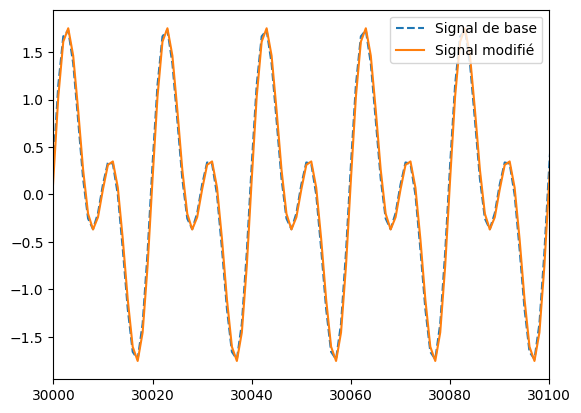

In [90]:
debut = 30000
ecart = 100
plt.plot(x_f0.real, '--', label="Signal de base")
plt.plot((n_signal.real), label="Signal modifié")
plt.legend()
plt.xlim(debut,debut+ecart)
plt.show()

## Application au changement de pitch

In [9]:
## Utiliser l'étirement temporel pour changer le pitch sans changer la durée